# Lexical particularities of Alorese

This notebook shows how to use LexiRumah to investigate the lexical differences between
two groups of languages in LexiRumah. As example, compare the lexicon of Alorese lects ([alor1247](http://glottolog.org/resource/languoid/id/alor1247)) with the lexicon of all other lects of Lamaholot ([lama1292](http://glottolog.org/resource/languoid/id/lama1292)) lects.

First we import a variety of necessary modules and define constants.

In [1]:
# Import generally useful modules
%matplotlib inline
from matplotlib import pyplot
import numpy
import itertools
from bisect import bisect
from collections import defaultdict, OrderedDict

In [2]:
# Import pylexirumah and related objects
from clldutils.path import Path
import pylexirumah
from pylexirumah.util import glottolog_clade, get_dataset, lexirumah_glottocodes

# Load the LexiRumah database
lexirumah = get_dataset()

We define the language groups: `alorese` will be all alorese lects in LexiRumah, `lamaholot` will contain all sedentary Lamaholot lects (spoken on Solor, Flores, Lembata etc., but not the Alorese lects of Alor and Pantar). In order to check for inheritance and cross-family borrowings, we define `an` and `tap` to be the groups of all other lects in the database, by family.

In [3]:
# This may take some time, our implementation of `glottolog_clade` is not built for speed.

alorese = glottolog_clade("alor1247", lexirumah)
print(alorese)

lamaholot = glottolog_clade("lama1292", lexirumah) - alorese
print(lamaholot)

floreslembata = glottolog_clade("flor1239", lexirumah) - alorese - lamaholot

an = glottolog_clade("aust1307", lexirumah) - alorese - lamaholot - floreslembata
tap = glottolog_clade("timo1261", lexirumah)

rest = set(lexirumah_glottocodes(lexirumah)) - alorese - lamaholot - floreslembata - an - tap
# There should not be any languages in the rest
assert not rest

groups = [alorese, lamaholot, floreslembata, an, tap]

{'alor1247-marisa', 'alor1247-munas', 'alor1247-besar', 'alor1247-baran', 'alor1247-pandai'}
{'lama1277-bama', 'lama1277-baipi', 'lama1277-imulo', 'lama1277-belan', 'lama1277-dulhi', 'lama1277-lewoe', 'lama1277-lewok', 'lama1277-minga', 'lama1277-lamal', 'lama1277-pukau', 'lama1277-tanju', 'lama1277-lerek', 'lama1277-botun', 'lama1277-lewot', 'lama1277-lamak', 'lama1277-merde', 'lama1277-paina', 'lama1277-ritae', 'lama1277-kalik', 'lama1277-waiba', 'lama1277-lewuk', 'lama1277-lamat', 'lama1277-ileap', 'lama1277-mulan', 'lama1277-lewom', 'lama1277-lewob', 'lama1277-lamah', 'lama1277-adona', 'lama1277-kiwan', 'lama1277-waiwa', 'lama1277-lewog', 'lama1277-lewoi', 'lama1277-lewop', 'lama1277-wuake', 'lama1277-watan', 'lama1277-horow'}


The LexiRumah database contains a `CognateTable`, which associates forms with cognate classes. In principle, different sources can assign one form to different classes. This is not the case at the moment where all forms are automatically generated. Going forwards, it will be a useful assumption that the newer cognate judgements occur later in the file, which is the semantics the by the following code block takes into account.

Explicitly prioritizing or ignoring a specific source can still be done by adding a filtering `if` statement to the following `for` loop.

In [4]:
# Aggregate cognate data from the Form and Cognate table.

# First, load the relevant content of the CognateTable into memory as dictionary.
cognateclass_by_form = {}
for cognate in lexirumah["CognateTable"].iterdicts():
    cognateclass_by_form[cognate["Form_ID"]] = cognate["Cognateset_ID"]

# Then, generate a sequence of all cognate classes, storing associations from the
# cognate class ID to the set of (concept, lect, form) tuples representing all forms
# belonging to that class.
cognates_by_class = {}
for form in lexirumah["FormTable"].iterdicts():
    concept = form["Concept_ID"]
    lect = form["Lect_ID"]
    cognates_by_class.setdefault(
        cognateclass_by_form.get(form["ID"]), set()).add(
        (concept, lect, form["Form"]))

In order to compare the lexical material of the two language groups, we now check what cognate classes are attested in which of the language groups. For now, all cognate sets in LexiRumah are restricted to one concept each, which simplifies the following calculation and interpretation.

In [5]:
# attested_cognate_sets is a dictionary, which associates concepts to a list of sets.
# The list contains one set for each language group defined above, and the set is a
# set of all cognate set IDs that express that concept in at least one lect of that
# group.
attested_cognate_sets = defaultdict(lambda: [set() for g_ in groups])
for name, cognates in cognates_by_class.items():
    lects = {lect for (concept, lect, form) in cognates}
    concept, _, _ = next(iter(cognates))
    
    for g, group in enumerate(groups):
        if lects & group:
            attested_cognate_sets[concept][g].add(name)

Now we can compare the lexicon. Starting with the most ‘stable’ concepts (we don't have a direct measure of stability, but we can assume that concepts with fewer cognate classes are more stable), we list those concepts where Alorese and Lamaholot have different cognate classes.

In [6]:
# Sort concepts by stability, by running an insertion sort with the help of bisect.
concepts = []
concept_stability = []
for concept, concept_classes in attested_cognate_sets.items():
    order = len(
        set.union(*concept_classes))
    i = bisect(concept_stability, order)
    concepts.insert(i, concept)
    concept_stability.insert(i, order)
# concepts is now a list of concept IDs, in order of stability.

cognateset_pattern_counts = numpy.zeros((2,) * len(groups) + (len(concepts),))

# Count the number of cognate classes for each pattern.
for c, concept in enumerate(concepts):
    attested_in_groups = attested_cognate_sets[concept]

    for pattern in itertools.product([0, 1], repeat=len(groups)):
        cognate_classes_for_pattern = set.union(*attested_in_groups)
        for present, classes in zip(pattern, attested_in_groups):
            if present:
                cognate_classes_for_pattern &= classes
            else:
                cognate_classes_for_pattern -= classes
        
        cognateset_pattern_counts[pattern][c] = len(cognate_classes_for_pattern)

# Genome-style plots

Every vertical line in the following bar plots corresponds to a concept; stable concepts on the left, unstable concepts on the right. Inside each bar, different types of cognate classes are plotted – every cognate class attested in that group is plotted with the same percentage, with colors corresponding to the apparent origin of the form.

In [7]:
def genomestyle(group_index=None, order=None):
    # Prepare the figure
    pyplot.gcf().set_size_inches((14, 3))
    #pyplot.axis('off')
    #pyplot.gca().get_xaxis().set_visible(False)
    #pyplot.gca().get_yaxis().set_visible(False)

    # Only count cognate classes present in group `group_index` – set all counts where
    # `group_index` is absent to 0.
    counts = cognateset_pattern_counts.copy()
    if group_index is not None:
        counts.swapaxes(group_index, 0)[0] = 0

    # Where `normalize` is 0, no forms for that concept are given. Ignore.
    b = numpy.zeros((len(concepts), len(colorize)))
    
    for c, (color, cells) in enumerate(colorize.items()):
        bar_height = 0
        for cell in cells:
            bar_height = counts[cell] + bar_height
        b[:, c] = bar_height

    # This complex expression sorts the bars as we want them, but keeps the data
    # structure an array for easier calculations.
    order = order or sorted(
        range(len(b)),
        key=lambda x: tuple(
            sum(b[x][n:]) for n in range(len(b[x]))))
    sorted_bars = b[order]

    bottom = 0
    for color, bars in zip(colorize, sorted_bars.T):
        pyplot.bar(
            range(len(bars)),
            bars,
            1.0,
            bottom = bottom,
            color = color)
        bottom = bottom + bars
    
    pyplot.xlabel("Concept")
    pyplot.ylabel("Number of classes")
    return order

In [8]:
colorize = OrderedDict()

Some cognate classes are present in Alorese and other AN languages (including the provided reconstructions of pMP and pAN). If they follow the hierarchy (see below), we give them all the same orange color. (In addition, this color is given to all hierarchically inherited forms that did not make it into Alorese, but this is only for completion's sake.)

That is, all similarity classes found in every group for one of the following diagrams is colored orange.

    (TAP < ) AN       (TAP < ) AN                 (TAP < ) AN             (TAP < ) AN
                                \                           \                       \
                 FL             FL     FL                   FL        FL            FL
                                        \                    \         \             \
                    LH                  LH      LH           LH        LH            LH
                                                 \                      \             \
                                                 AL                     AL            AL



As an exception from that hierarchical inheritance color, Forms found in Alorese which are judged dissimilar to any other forms get the color purple marking them as “Alorese-specific”.

In [9]:
# Hierarchical inheritance
colorize[(1, 0.7, 0.2)] = [
    (1, 1, 1, 1, 1),
    (0, 1, 1, 1, 1),
    (0, 0, 1, 1, 1),
    (0, 0, 0, 1, 1),
    (1, 1, 1, 1, 0),
    (0, 1, 1, 1, 0),
    (0, 0, 1, 1, 0),
    (0, 0, 0, 1, 0),
    (1, 1, 1, 0, 0),
    (0, 1, 1, 0, 0), 
    (0, 0, 1, 0, 0),
    (1, 1, 0, 0, 0),
    (0, 1, 0, 0, 0)]

Similarity classes that are found in TAP, and outside TAP only in Alorese, are a priori easily explained as TAP loans, so they will all be colored green. (In the complete listing, that color is also chosen for all classes found in TAP, but not outside that family.)

In [10]:
# TAP forms
colorize[(0.0, 0.8, 0.0)] = [
     (1, 0, 0, 0, 1),
     (0, 0, 0, 0, 1)]
        

If a cognate class is attested in Alorese and other Flores-Lembata languages, but not in any Lamaholot dialect, that is slightly unexpected under the hypothesis that Alorese is a daughter, not a sister, of Lamaholot. We color those similarity classes in yellow.

Similarly, we assign the same yellow color to all classes that have an unexpected distribution. This includes
 1. All forms that “skipped” a clade in the inhertance hierarchy, eg. similarity classes found in AN, Alorese, and other Flores-Lembata languages, but not in any Lamaholot dialect;
 2. Similarity classes found in Timor-Alor-Pantar languages, but which in the Austronesian languages are found only in the wider Flores-Lembata languages.
 

In [11]:
# Unexpected distribution
colorize[(0.9, 0.9, 0.0)] = [
    (1, 0, 1, 1, 1),
    (1, 0, 1, 1, 0),
    (1, 0, 1, 0, 0),
    (1, 0, 0, 1, 1),
    (1, 1, 0, 1, 1),
    (0, 1, 0, 1, 1), 
    (1, 0, 0, 1, 0),
    (1, 1, 0, 1, 0),
    (0, 1, 0, 1, 0),
    (1, 1, 1, 0, 1),
    (0, 1, 1, 0, 1),
    (0, 0, 1, 0, 1),
    (1, 1, 0, 0, 1),
    (0, 1, 0, 0, 1),
    (1, 0, 1, 0, 1)]


In [12]:
# Alorese forms
colorize[(0.8, 0.1, 1.0)] = [
    (1, 0, 0, 0, 0)]

In [13]:
# This should be all combinations.
all_patterns = [(0,) * len(groups)]
for patterns in colorize.values():
    all_patterns.extend(patterns)
for i, j in zip(sorted(all_patterns), sorted(itertools.product([0, 1], repeat=len(groups)))):
    if i!=j:
        print("expected:", j, "but found:", i)

# Genome-style plot of the entire database
The plots below sort concepts by their local stability. If you want a specific order, eg. order by global stability, you have to calculate that order and pass it to those plotting functions as argument. Here, the output is the distribution of these classes over the entire database.

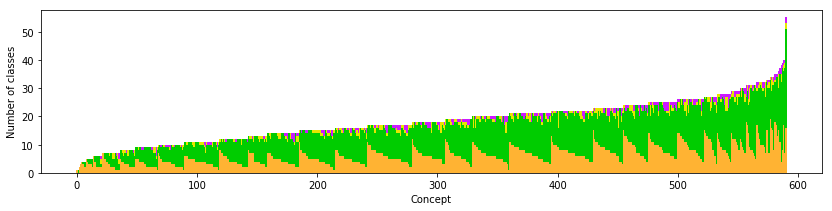

In [14]:
order = genomestyle(None, order=None)

## TAP forms

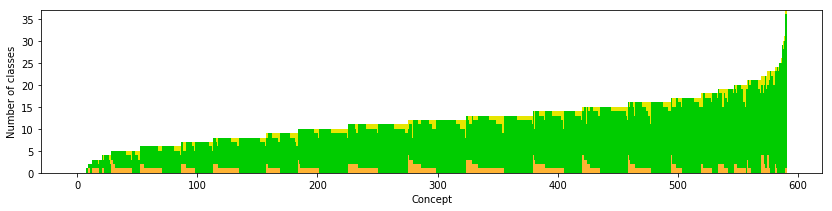

In [15]:
_ = genomestyle(4, order=None)

## Alorese forms

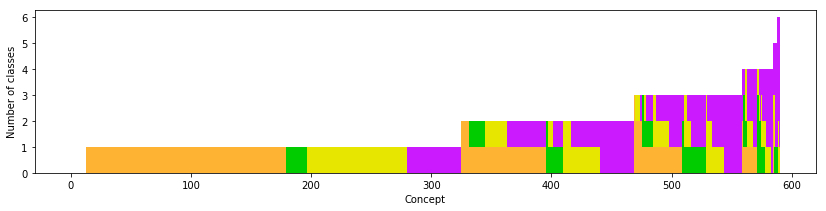

In [16]:
_ = genomestyle(0, order=None)

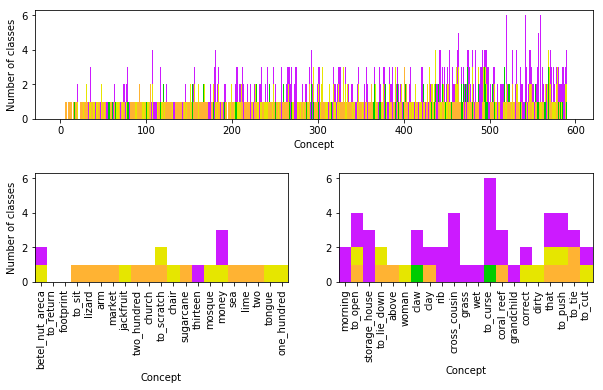

In [32]:
pyplot.subplot2grid((2, 2), (0, 0), colspan=2)

_ = genomestyle(0, order=order)

concepts_in_order = [concepts[o] for o in order]

pyplot.subplot2grid((2, 2), (1, 0))
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(19.5, 40.5)

pyplot.subplot2grid((2, 2), (1, 1))
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(529.5, 550.5)
pyplot.ylabel("")

pyplot.gcf().set_size_inches((10, 5))
pyplot.subplots_adjust(hspace=0.5)

pyplot.savefig("Fig7.eps", format='eps', dpi=600)

(19.5, 80.5)

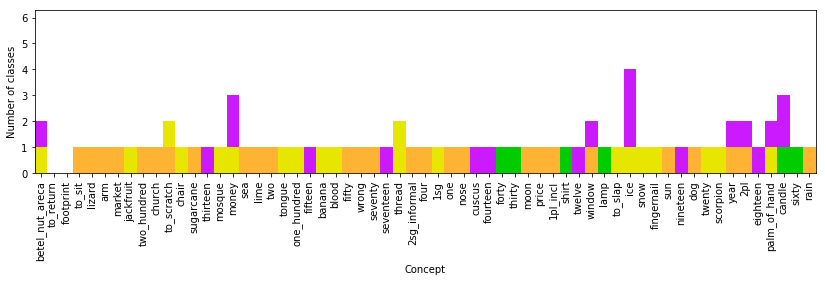

In [19]:
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(19.5, 80.5)

## Examples: a few of the concepts seen in the figures above

In [20]:
for c in attested_cognate_sets["lizard"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-munas tə'kːɛʔ
alor1247-besar ta'kːe
alor1247-pandai ta'kːe
LH
lama1277-lewoi ˈtəkɛʔ
lama1277-kalik təˈkɛk
lama1277-lerek təˈkɛk
lama1277-adona ˈtɜke
FL
sika1262-hewa təke:
keda1252-leuba tɛ'kɛʔ
AN
tetu1245-suai toko
p-mala1545-acd *tektek
tetu1245-vique toko
koto1251 ʔteke
TAP
abui1241-fuime tekok
blag1240-tuntu texe
fata1247 tɔkɛ
rett1240 tɛk
sarr1247-adiab teh
blag1240-nule te'ke
maka1316 toke
dein1238 teih
baka1276 tekek
sarr1247-nule taqo
adan1251-lawah teko
buna1278-bobon thɔkɔh
teiw1235 taqoq
kuii1253 takók
adan1251-otvai ’tɛko
sawi1256 ta'kɔ
blag1240-warsa texe
abui1241-takal te̞̞qɔɁ
kira1248 taˈkok
kama1365 takːeː
pura1258 teke
abui1241-ulaga taŋkok
rett1240 tek
abui1241-takal te̞̞qɔq
lamm1241-westp tak:a
kaer1234 tɛk
blag1240-bama texe
kelo1247-hopte ta'kɛk
buna1278-suai thɔkɔh
atim1239 tekok
kabo1247 teko
kula1280-lanto tko
blag1240-kulij tekeʔ
kula1280-lanto tə’ko


In [21]:
for c in attested_cognate_sets["thirteen"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-munas kər'tou 'ilak tə'lːɔ
alor1247-besar kartou 'ilaka 'talːɔ
alor1247-pandai kə'rtou 'ilak 'talːɔ
LH
FL
AN
TAP


In [22]:
for c in attested_cognate_sets["tongue"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-besar fɛ'fɛlɛŋ
alor1247-munas wɛwɛl
alor1247-baran fɛfɛl
alor1247-pandai wɛwɛl
LH
lama1277-lewuk ewel
lama1277-waiba wewel
lama1277-lewom wewe
lama1277-watan wewer
lama1277-kiwan weweyək
lama1277-lamal efel
lama1277-baipi wewe
lama1277-paina eweləg
lama1277-lewot efel
lama1277-kalik ewel
lama1277-bama wewel
lama1277-mulan ewel
lama1277-horow wewer
lama1277-wuake ewel
lama1277-kalik eˈvɛl
lama1277-lewog wewel
lama1277-lamah ewel
lama1277-dulhi wewen
lama1277-belan ewel
lama1277-pukau wewel
lama1277-lerek eˈwel
lama1277-lewob wewe
lama1277-lewoi ˈweweˈləŋ
lama1277-adona ˈɜwɜˈrɜt
lama1277-lamak ewel
lama1277-lewok ewel
lama1277-botun wewe
lama1277-merde ewelə
lama1277-tanju wewel
lama1277-lewop efel
lama1277-imulo efeləs
lama1277-ritae wewel
lama1277-ileap ewel
lama1277-minga efel
lama1277-waiwa wewer
FL
AN
TAP
sarr1247-adiab pe'fal
maka1316 ifi'leru
dein1238 nawas:aŋ


In [23]:
for c in attested_cognate_sets["church"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


AL
alor1247-besar ga'rɛʤa
alor1247-munas gər'dʒa
alor1247-pandai uma gə'rɛdʒa
LH
lama1277-adona ɡɜˈrɛdʒa
lama1277-lewoi ɡeˈrɛʤa
FL
keda1252-leuba ɡə'rɛdʒa
sika1262-hewa gereʤa
AN
tetu1245-vique uma 'kreda
tetu1245-suai uma 'kreda
TAP
rett1240 garaʤa
adan1251-otvai ga’rɛɟa
teiw1235 gə'reja
kelo1247-hopte gə'reɟ
pura1258 ga'rija


In [24]:
for c in attested_cognate_sets["claw"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)
    print()

print()
print("For context, the forms in Lamaholot:")
for c in attested_cognate_sets["claw"][1]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)

AL
alor1247-baran limɑŋ ta'nuŋgul
LH
FL
AN
TAP

AL
alor1247-pandai k'rako
alor1247-besar ga'raku
LH
FL
AN
TAP
sawi1256 kə'riki
buna1278-bobon galakha

AL
alor1247-munas kɛla 'leiŋ
LH
FL
AN
TAP


For context, the forms in Lamaholot:
AL
LH
lama1277-lerek kabəˈlən
FL
AN
TAP
AL
LH
lama1277-adona kɜˈmukure
FL
AN
p-mala1545-acd *kuhkuh
TAP
kelo1247-bring gɛkuh
AL
LH
lama1277-lewoi təˈnuʔi
FL
AN
TAP


In [25]:
for concept in concepts:
    by_group = attested_cognate_sets[concept]
    if by_group[0] != by_group[1]:
        if by_group[0] and by_group[1]:
            fl_skipping_l = (by_group[0] & by_group[2]) - by_group[1]
            an_skipping_l = (by_group[0] & by_group[3]) - by_group[1]
            skipping = fl_skipping_l | an_skipping_l
            a_but_not_l = by_group[0] - by_group[1]
            l_skipping_a = by_group[1] - by_group[0]

            print("Concept ‘{:}’ is different between Alorese and Lamaholot.".format(
                concept))
            print()
            if (a_but_not_l - skipping) - by_group[4]:
                print("", "Alorese innovated the following forms:")
                for cognateclass in a_but_not_l - skipping:
                    print("", cognates_by_class[cognateclass])
            if (a_but_not_l - skipping) & by_group[4]:
                print("", "Alorese shares the following forms with TAP languages:")
                for cognateclass in a_but_not_l - skipping:
                    print("", cognates_by_class[cognateclass])
            if skipping:
                print("", "Alorese shares the following forms with other AN languanges, but not Lamaholot:")
                for cognateclass in skipping:
                    print("", cognates_by_class[cognateclass])
            if l_skipping_a:
                print("", "One or more Lamaholot dialects innovated forms not found in Alorese:")
                for cognateclass in l_skipping_a:
                    print("", cognates_by_class[cognateclass])
            if by_group[1] & by_group[0]:
                print()
                print(" ", "Just for clarity:")
                print(" ", "There are also the following similarity classes shared between Alorese and LH.")
                for cognateclass in by_group[1] & by_group[0]:
                    print(" ", cognates_by_class[cognateclass])
        elif by_group[0]:
            print("Concept {:} is attested only in Alorese".format(concept))
        elif by_group[1]:
            print("Concept {:} is attested only in Lamaholot".format(concept))
        print("\n\n")
        


Concept roof_rafter is attested only in Lamaholot



Concept some is attested only in Lamaholot



Concept dew is attested only in Lamaholot



Concept dibble_stick is attested only in Lamaholot



Concept fist is attested only in Lamaholot



Concept ‘hand’ is different between Alorese and Lamaholot.

 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('hand', 'lama1277-adona', 'ˈnaiʔjũ')}

  Just for clarity:
  There are also the following similarity classes shared between Alorese and LH.
  {('hand', 'p-aust1307-abvd', '*(qa)lima'), ('hand', 'keda1252', 'liŋ'), ('hand', 'lama1277-botun', 'lima'), ('hand', 'lama1277-lewog', 'lima'), ('hand', 'lama1277-lamal', 'limate'), ('hand', 'lama1277-lewok', 'limaga'), ('hand', 'lama1277-kalik', 'limaga'), ('hand', 'tetu1245-suai', 'liman'), ('hand', 'lama1277-lewop', 'limaha'), ('hand', 'alor1247-munas', 'limaŋ'), ('hand', 'lama1277-waiwa', 'limak'), ('hand', 'sika1262-maume', 'liman'), ('hand', 'lama1277-belan', 'limak'), 

Concept ‘to_dwell’ is different between Alorese and Lamaholot.

 Alorese innovated the following forms:
 {('to_dwell', 'alor1247-besar', 'tɔbɔ'), ('to_dwell', 'alor1247-pandai', 'tɔbɔ'), ('to_dwell', 'alor1247-munas', 'tɔbɔ')}
 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('to_dwell', 'lama1277-lerek', 'ˈmian'), ('to_dwell', 'lama1277-kalik', "-'ia")}
 {('to_dwell', 'lama1277-lewoi', 'ˈtei')}
 {('to_dwell', 'lama1277-adona', 'ˈtawãnɜt')}



Concept ‘ritual_mound’ is different between Alorese and Lamaholot.

 Alorese innovated the following forms:
 {('ritual_mound', 'alor1247-pandai', "wato 'ua 'mau 'uliŋ")}
 {('ritual_mound', 'kelo1247-hopte', 'dur'), ('ritual_mound', 'rett1240', 'dɔru'), ('ritual_mound', 'adan1251-otvai', '’dɔr'), ('ritual_mound', 'alor1247-besar', 'dolu'), ('ritual_mound', 'kaer1234', 'dor'), ('ritual_mound', 'alor1247-munas', 'dɔru'), ('ritual_mound', 'pura1258', 'doru')}
 {('ritual_mound', 'alor1247-pandai', "wato p'lawak")}
 Alorese shar

 {('flying_fox', 'lama1277-adona', 'ˈʔobɔʔ')}
 {('flying_fox', 'lama1277-kalik', 'kəmiˈki'), ('flying_fox', 'lama1277-lerek', 'miˈker'), ('flying_fox', 'lama1277-kalik', 'kəmiˈkɛr')}
 {('flying_fox', 'lama1277-lewoi', 'ˈbɔkɑŋ')}



Concept ‘with’ is different between Alorese and Lamaholot.

 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('with', 'lamm1241-westp', 'gra'), ('with', 'lamm1241-westp', '-r'), ('with', 'lama1277-lewoe', 'rua')}
 {('with', 'tetu1246', 'hɔ:'), ('with', 'sika1262-hewa', '-ora'), ('with', 'idat1237', 'ʔɔrɔ:'), ('with', 'tuku1254', 'ʔɔ:'), ('with', 'lama1277-lamat', 'ʔo')}
 {('with', 'lamm1241-westp', 'gar'), ('with', 'lama1277-lamah', 'kã'), ('with', 'lama1277-kalik', 'ko'), ('with', 'lama1277-merde', 'ko')}
 {('with', 'abui1241-ulaga', 'va'), ('with', 'abui1241-takal', 'fäl'), ('with', 'lama1277-minga', 'we'), ('with', 'abui1241-ulaga', 'fa'), ('with', 'kula1280-lanto', 'wɛ'), ('with', 'lama1277-lewot', 'fe')}
 {('with', 'lama1277-adona


  Just for clarity:
  There are also the following similarity classes shared between Alorese and LH.
  {('to_blow', 'lamm1241-westp', 'pujaŋ'), ('to_blow', 'lama1277-kalik', 'pur'), ('to_blow', 'lamm1241-westp', 'pus:a'), ('to_blow', 'adan1251-otvai', '’apu'), ('to_blow', 'lamm1241-westp', 'pusakai'), ('to_blow', 'lama1277-kiwan', 'puit'), ('to_blow', 'lama1277-lamak', 'pui'), ('to_blow', 'lama1277-lewog', 'bu'), ('to_blow', 'teiw1235', 'pui'), ('to_blow', 'lama1277-botun', 'bu'), ('to_blow', 'lama1277-lewok', 'pur'), ('to_blow', 'kelo1247-hopte', 'pu'), ('to_blow', 'blag1240-kulij', 'up:uʔ'), ('to_blow', 'dein1238', 'pui'), ('to_blow', 'sika1262-hewa', 'plupi'), ('to_blow', 'keda1252-leuba', 'puiʔ'), ('to_blow', 'lama1277-lewom', 'bu'), ('to_blow', 'lama1277-lewoi', 'buː'), ('to_blow', 'pura1258', 'apu'), ('to_blow', 'alor1247-besar', 'pui'), ('to_blow', 'alor1247-baran', 'pui'), ('to_blow', 'lama1277-waiwa', 'bu'), ('to_blow', 'adan1251-lawah', 'apaʔu'), ('to_blow', 'lama1277-bama',

  There are also the following similarity classes shared between Alorese and LH.
  {('sky', 'alor1247-pandai', 'kalːeŋ'), ('sky', 'sika1262-hewa', 'kəleŋ'), ('sky', 'lama1277-merde', 'kəlã'), ('sky', 'lama1277-ileap', 'kələm'), ('sky', 'lama1277-tanju', 'kəlã'), ('sky', 'lama1277-lewop', 'kələm'), ('sky', 'lama1277-kalik', 'kəˈləm'), ('sky', 'lama1277-wuake', 'kələm'), ('sky', 'lama1277-lewot', 'kələmu'), ('sky', 'lama1277-ritae', 'kəlã'), ('sky', 'lama1277-lamah', 'kələm'), ('sky', 'kama1365', 'deliŋ'), ('sky', 'lama1277-bama', 'kəlã'), ('sky', 'lama1277-adona', 'ˈkɜlɜ'), ('sky', 'lama1277-lewog', 'kəlã'), ('sky', 'lama1277-minga', 'kələm'), ('sky', 'lama1277-lewuk', 'kələm'), ('sky', 'lama1277-horow', 'kəlã'), ('sky', 'lama1277-imulo', 'kələm'), ('sky', 'lama1277-lamal', 'kelã'), ('sky', 'keda1252-leuba', "ʔɛ'leŋ"), ('sky', 'lama1277-waiba', 'kəlẽ'), ('sky', 'keda1252', 'eleŋ'), ('sky', 'lama1277-lewok', 'kələm'), ('sky', 'lama1277-mulan', 'kəlɤ'), ('sky', 'lama1277-lewoi', 'ˈ

 {('blind', 'alor1247-pandai', "mataŋ 'date"), ('blind', 'tetu1245-vique', 'mata at'), ('blind', 'tetu1245-suai', 'mata at'), ('blind', 'alor1247-besar', "mataŋ 'date")}
 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('blind', 'lama1277-adona', 'kɜˈbuʔlɔ̃')}
 {('blind', 'p-mala1545-acd', '*buta'), ('blind', 'lamm1241-westp', 'taiti bad:aŋ'), ('blind', 'kama1365', 'bita'), ('blind', 'lamm1241-westp', 'bad:aŋ'), ('blind', 'lama1277-lewoi', 'ˈbuta')}
 {('blind', 'lama1277-lerek', 'maˈta kiˈpɛk'), ('blind', 'lama1277-kalik', 'kniˈpɛk')}
 {('blind', 'lama1277-adona', 'kɜˈnisũ')}



Concept ‘brother’ is different between Alorese and Lamaholot.

 Alorese innovated the following forms:
 {('brother', 'alor1247-pandai', 'tata')}
 {('brother', 'alor1247-pandai', 'ula')}
 {('brother', 'alor1247-besar', "naŋ ka'lake")}
 Alorese shares the following forms with other AN languanges, but not Lamaholot:
 {('brother', 'sika1262-hewa', 'nara'), ('brother', 'alor1247-pandai', 'naŋ

  There are also the following similarity classes shared between Alorese and LH.
  {('to_suck', 'lama1277-baipi', 'tuho'), ('to_suck', 'lama1277-pukau', 'tuho'), ('to_suck', 'lama1277-lewok', 'tusu'), ('to_suck', 'lama1277-mulan', 'tuho'), ('to_suck', 'sika1262-hewa', 'wuhu'), ('to_suck', 'lama1277-tanju', 'tuho'), ('to_suck', 'lama1277-ileap', 'tuho'), ('to_suck', 'lama1277-horow', 'tuho'), ('to_suck', 'lama1277-waiwa', 'tuho'), ('to_suck', 'lama1277-lewom', 'tuho'), ('to_suck', 'keda1252-leuwa', 'dupεŋ'), ('to_suck', 'lama1277-lamak', 'tuho'), ('to_suck', 'alor1247-besar', 'dumɔ'), ('to_suck', 'lama1277-lewop', 'tuhu'), ('to_suck', 'lama1277-belan', 'tuo'), ('to_suck', 'lama1277-lewob', 'tuho'), ('to_suck', 'alor1247-baran', 'dum:ɔ'), ('to_suck', 'lama1277-ritae', 'tuho'), ('to_suck', 'lama1277-watan', 'tuho'), ('to_suck', 'lama1277-lamal', 'tu (ana)'), ('to_suck', 'lama1277-lewoe', 'tuhu'), ('to_suck', 'lama1277-merde', 'tuho'), ('to_suck', 'lama1277-botun', 'tuho'), ('to_suck', 'la

 {('to_be_silent', 'lama1277-lewoi', 'ˈkəpərə'), ('to_be_silent', 'lama1277-kalik', 'kəˈpae')}
 {('to_be_silent', 'lama1277-kalik', 'məˈli')}



Concept ‘scared’ is different between Alorese and Lamaholot.

 One or more Lamaholot dialects innovated forms not found in Alorese:
 {('scared', 'lama1277-lewoe', 'goʔə')}
 {('scared', 'lama1277-kalik', 'têmêkon')}
 {('scared', 'lama1277-minga', 'kərui'), ('scared', 'lama1277-lamal', 'kəruit'), ('scared', 'lama1277-belan', 'kərui'), ('scared', 'lama1277-lewot', 'kəruit'), ('scared', 'lama1277-lewop', 'keruit'), ('scared', 'lama1277-wuake', 'kərui'), ('scared', 'lama1277-imulo', 'kəruitəs')}
 {('scared', 'lama1277-dulhi', 'soʔot'), ('scared', 'lama1277-lamak', 'soʔo'), ('scared', 'lama1277-adona', 'ˈsoʔot'), ('scared', 'lama1277-horow', 'soʔot'), ('scared', 'lama1277-ileap', 'soʔot'), ('scared', 'lama1277-waiwa', 'soʔot'), ('scared', 'lama1277-botun', 'soʔot'), ('scared', 'lama1277-kiwan', 'soʔot'), ('scared', 'lama1277-watan', 'soʔo'), ('scare

  There are also the following similarity classes shared between Alorese and LH.
  {('earthworm', 'alor1247-pandai', "ula 'wali"), ('earthworm', 'lama1277-adona', 'kalaˈwala'), ('earthworm', 'alor1247-munas', "ula 'wali"), ('earthworm', 'kira1248', 'biliwali'), ('earthworm', 'alor1247-besar', "fali-'fali"), ('earthworm', 'lama1277-lewoi', 'ulaˈwala'), ('earthworm', 'alor1247-baran', ",ʔula 'fale")}



Concept ‘traditional_house’ is different between Alorese and Lamaholot.

 Alorese innovated the following forms:
 {('traditional_house', 'alor1247-munas', "uma 'lɛlaŋ")}
 {('traditional_house', 'alor1247-pandai', 'kɔkɔr'), ('traditional_house', 'rett1240', 'kokor')}
 {('traditional_house', 'alor1247-pandai', "uma 'adat"), ('traditional_house', 'alor1247-besar', "uma 'hada"), ('traditional_house', 'alor1247-munas', "uma 'adat")}
 Alorese shares the following forms with TAP languages:
 {('traditional_house', 'alor1247-munas', "uma 'lɛlaŋ")}
 {('traditional_house', 'alor1247-pandai', 'kɔkɔr'